In [1]:
import os
import numpy as np
#import tensorflow as tf
import time

# setup for jupyter notebook
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# create simulation data
FLAG_use_real_data = True
FLAG_load_real_data = True
FLAG_create_data = False
FLAG_save_data = True and not FLAG_load_real_data
FLAG_load_data = not FLAG_create_data

feature_dim = 3325

# total: 700 days, 500 heaters, 2450 features
if FLAG_create_data and not FLAG_use_real_data:
    num_heaters = 20

    zero_center = -0.5
    one_center = 0.5

    X1 = np.random.normal(one_center, size=(700 * num_heaters // 2, 1)).astype(np.float32) * np.ones((700 * num_heaters // 2, feature_dim))
    X2 = np.random.normal(zero_center, size=(700 * num_heaters // 2, 1)).astype(np.float32) * np.ones((700 * num_heaters // 2, feature_dim))
    X = np.concatenate([X1, X2], axis=0)
    Y = np.concatenate([np.ones(700 * num_heaters // 2, dtype=np.int32), np.zeros(700 * num_heaters // 2, dtype=np.int32)])

    test_Xmix = np.random.normal((zero_center + one_center) / 2.0, size=(200, 1)).astype(np.float32) * np.ones((200, feature_dim))
    test_X0 = np.random.normal(zero_center, size=(200, 1)).astype(np.float32) * np.ones((200, feature_dim))
    test_X1 = np.random.normal(one_center, size=(200, 1)).astype(np.float32) * np.ones((200, feature_dim))
    test_X = np.concatenate([test_X0, test_X1], axis=0)
    test_Y = np.concatenate([np.zeros(200, dtype=np.int32), np.ones(200, dtype=np.int32)])

    if FLAG_save_data and not FLAG_use_real_data:
        np.savez_compressed("M:\\cs341_swap\\sim_200", X, Y, test_X, test_Y, test_Xmix)

if FLAG_load_data and not FLAG_use_real_data:
    arrs = np.load("M:\\cs341_swap\\sim_200.npz")
    X, Y, test_X, test_Y, test_Xmix = arrs["arr_0"], arrs["arr_1"], arrs["arr_2"], arrs["arr_3"], arrs["arr_4"]
    
if FLAG_use_real_data and not FLAG_load_real_data:
    tic = time.clock()
    train_data_raw = []
    train_dir = "E:\\cs341-project\\iotdata\\npz_feats_all\\train"
    for one_file in os.listdir(train_dir):
        if one_file.endswith(".feats.npz"):
            mat = np.load(os.path.join(train_dir, one_file))["arr_0"]
            advanced_feats = np.zeros([mat.shape[0], mat.shape[1] * 2 - 1])
            for line_idx in range(min(10, mat.shape[0])):
                advanced_feats[line_idx, :mat.shape[1]] = mat[line_idx, :]
                advanced_feats[line_idx, mat.shape[1]:] = -1
            for line_idx in range(10, mat.shape[0]):
                advanced_feats[line_idx, :mat.shape[1]] = mat[line_idx, :]
                advanced_feats[line_idx, mat.shape[1]:] = np.mean(mat[line_idx - 10:line_idx - 3,:], axis=0)[1:]
                
            #train_data_raw.append(mat)
            train_data_raw.append(advanced_feats)

    train_data = np.concatenate(train_data_raw)
    X = train_data[:, 1:]
    Y = (train_data[:, 0]).astype(np.int32)
    
    test_data_raw = []
    test_dir = "E:\\cs341-project\\iotdata\\npz_feats_all\\test"
    for one_file in os.listdir(test_dir):
        if one_file.endswith(".feats.npz"):
            mat = np.load(os.path.join(test_dir, one_file))["arr_0"]
            advanced_feats = np.zeros([mat.shape[0], mat.shape[1] * 2 - 1])
            for line_idx in range(min(10, mat.shape[0])):
                advanced_feats[line_idx, :mat.shape[1]] = mat[line_idx, :]
                advanced_feats[line_idx, mat.shape[1]:] = -1
            for line_idx in range(10, mat.shape[0]):
                advanced_feats[line_idx, :mat.shape[1]] = mat[line_idx, :]
                advanced_feats[line_idx, mat.shape[1]:] = np.mean(mat[line_idx - 10:line_idx - 3,:], axis=0)[1:]
                
            #test_data_raw.append(mat)
            test_data_raw.append(advanced_feats)

    test_data = np.concatenate(test_data_raw)
    test_X = test_data[:, 1:]
    test_Y = (test_data[:, 0]).astype(np.int32)
    
    toc = time.clock()
    print("[%ds] loaded ori data done" % (toc-tic))
          
    if FLAG_save_data:
        tic = time.clock()
        np.savez_compressed("M:\\cs341_swap\\adv_feats", X, Y, test_X, test_Y)
        toc = time.clock()
        print("[%ds] saved." % (toc-tic))
    
if FLAG_use_real_data and FLAG_load_real_data:
    tic = time.clock()
    D = np.load("M:\\cs341_swap\\adv_feats.npz")
    X = D["arr_0"]
    Y = D["arr_1"]
    test_X = D["arr_2"]
    test_Y = D["arr_3"]
    
    balanced_Y_pos = Y[Y == 1]
    balanced_Y_neg = Y[Y == 0]
    balanced_Y_neg_idx = list(range(np.sum(Y == 0)))
    np.random.shuffle(balanced_Y_neg_idx)
    balanced_Y_neg_idx = balanced_Y_neg_idx[:np.sum(balanced_Y_pos) * 5]
    balanced_Y = np.concatenate([balanced_Y_pos, balanced_Y_neg[balanced_Y_neg_idx]])
    
    balanced_X_pox = X[Y == 1]
    balanced_X_neg = X[Y == 0]
    balanced_X = np.concatenate([balanced_X_pox, balanced_X_neg[balanced_Y_neg_idx]])
    
    balance_shuffle_idx = list(range(len(balanced_Y)))
    np.random.shuffle(balance_shuffle_idx)
    balanced_Y = balanced_Y[balance_shuffle_idx]
    balanced_X = balanced_X[balance_shuffle_idx]
    
    toc = time.clock()
    print("[%ds] loaded %d train records with %d pos days; %d train records and %d pos days after balance" 
          % (toc-tic, len(Y), sum(Y), len(balanced_Y), sum(balanced_Y)))

    print("[%ds] loaded %d test records with %d pos days" % (toc-tic, len(test_Y), sum(test_Y)))

[8s] loaded 35424 train records with 1734 pos days; 10404 train records and 1734 pos days after balance
[8s] loaded 8139 test records with 369 pos days


In [ ]:
# tf classifier with cross entropy loss

import tensorflow as tf
from logistic_tf import LinearClassifier

classifier = LinearClassifier(X.shape[1], loss_func = "hinge", learning_rate=1e-4, reg=1e-10)
loss_hist = classifier.fit(balanced_X, balanced_Y, batch_size=0, num_iters=6000, verbose=True, verbose_iter=100)
print(classifier.evaluate(balanced_X, balanced_Y))
print(classifier.evaluate(test_X, test_Y))
#print(classifier.predict(test_Xmix))
print(balanced_Y, classifier.predict(balanced_X))
pred_y = classifier.predict(test_X).astype(np.int32)
classifier.reset()

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
classifier.reset()

In [28]:
# sklearn SVC
from sklearn.svm import SVC

tic = time.time()
svc = SVC(probability=False, class_weight={0:1, 1:10}, verbose=True, max_iter=2000, C=1e-0, gamma=1e-7)
svc.fit(X, Y)
pred_y = svc.predict(test_X)
toc = time.time()
print('%fs' % (toc - tic))
#print(svc.score(balanced_X, balanced_Y))

[LibSVM]1539.002000s


[1 0 0 ..., 1 1 1]
             precision    recall  f1-score   support

          0       0.94      0.30      0.46      7770
          1       0.04      0.56      0.07       369

avg / total       0.90      0.32      0.44      8139

0.433966370552


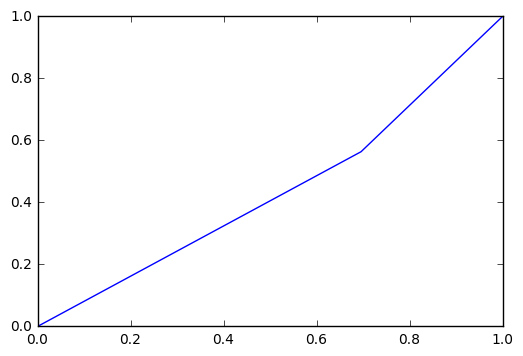

In [29]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

pred_y = pred_y.astype(np.int32)
print(pred_y)
print(classification_report(test_Y, pred_y))
print(roc_auc_score(test_Y, pred_y))
fpr, tpr, thresholds = roc_curve(test_Y, pred_y)
plt.plot(fpr, tpr)
plt.show()

In [30]:
pred_y = svc.predict(balanced_X)
# pred_y = svc.predict(test_X)

             precision    recall  f1-score   support

          0       1.00      0.37      0.54      8670
          1       0.24      1.00      0.39      1734

avg / total       0.87      0.48      0.52     10404

0.685351787774


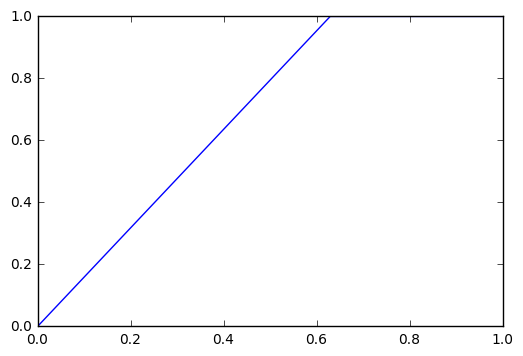

In [31]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print(classification_report(balanced_Y, pred_y))
print(roc_auc_score(balanced_Y, pred_y))
fpr, tpr, thresholds = roc_curve(balanced_Y, pred_y)
plt.plot(fpr, tpr)
plt.show()

In [19]:
print(X.shape)

(35424L, 6650L)
